In [1]:
from plantcv import plantcv as pcv
from pathlib import Path

from leafy.loader import ImageLoader

data_folder = Path("./images")
loader = ImageLoader(data_folder)    

# Colors

In [2]:
from torchvision.transforms.functional import to_tensor, to_pil_image
from leafy.types import rgb_image, mask, rgb_image_cv

import random
from PIL import Image

index = random.randint(0, len(loader) - 1)
im, y = loader[index]
im_path = loader.image_files[index]
img, path, filename = pcv.readimage(filename=str(im_path))

#Threshold your image by choosing points in the plot that will separate the green plant pixels from everything else. 
# It will draw a line between your two points and take every pixel "above" (if set to true). Do you get all of the plant?

# thresh1 = pcv.threshold.dual_channels(rgb_img = img, x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)


# Image.fromarray(thresh1)

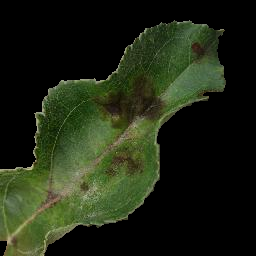

In [3]:
import numpy as np
from torch import Tensor
import torch

def tensor_to_cv(im: rgb_image) -> rgb_image_cv:
    # return (im.transpose(0, 1).transpose(1, 2) * 255).numpy().astype(np.uint8)
    return np.array(to_pil_image(im))[:,:,::-1]


def get_mask(im: rgb_image) -> mask:
    im_cv = tensor_to_cv(im)
    # im_last = im.transpose(0, 1).transpose(1, 2)
    thresh1 = pcv.threshold.dual_channels(rgb_img = im_cv, x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)
    thresh1 = pcv.fill_holes(thresh1)
    return Tensor(thresh1 / 255.)

mask = get_mask(im)
to_pil_image(mask * im)

In [4]:
color_histogram = pcv.analyze.color(rgb_img=tensor_to_cv(im), labeled_mask=mask, colorspaces='all', label="default")
color_histogram

alt.FacetChart(...)

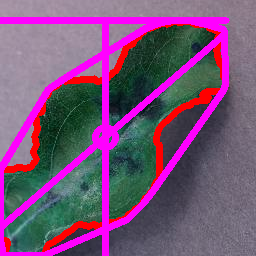

In [5]:
def cv_to_tensor(im: rgb_image_cv) -> rgb_image:
    return to_tensor(Image.fromarray(im))
    return im.transpose(2, 0, 1)[:,:,::1]


pcv.params.line_thickness = 5
shape_image = pcv.analyze.size(img=tensor_to_cv(im), labeled_mask=mask.to(torch.uint8).numpy() * 255, n_labels=1)
# Image.fromarray(shape_image)
# cv_to_tensor(shape_image).shape
shape_image.transpose(2, 0, 1).shape
# conve = Tensor(np.array(shape_image.transpose(2, 0, 1))
to_pil_image(cv_to_tensor(shape_image))

In [6]:
type(shape_image)

numpy.ndarray

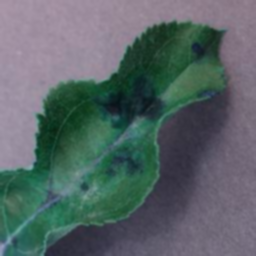

In [7]:
gaussian_img = pcv.gaussian_blur(img=tensor_to_cv(im), ksize=(5, 5), sigma_x=0, sigma_y=None)
Image.fromarray(gaussian_img)

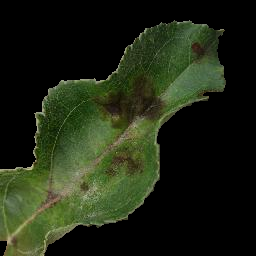

In [8]:
import numpy as np
from torch import Tensor
import torch

def tensor_to_cv(im: rgb_image) -> rgb_image_cv:
    # return (im.transpose(0, 1).transpose(1, 2) * 255).numpy().astype(np.uint8)
    return np.array(to_pil_image(im))[:,:,::-1].copy()


def get_mask(im: rgb_image) -> mask:
    im_cv = tensor_to_cv(im)
    # im_last = im.transpose(0, 1).transpose(1, 2)
    thresh1 = pcv.threshold.dual_channels(rgb_img = im_cv, x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)
    thresh1 = pcv.fill_holes(thresh1)
    return Tensor(thresh1 / 255.)

mask = get_mask(im)
to_pil_image(mask * im)

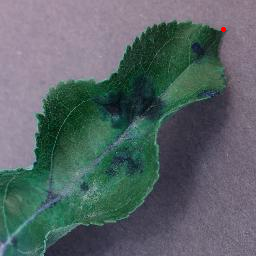

In [9]:
import cv2
from copy import deepcopy
homolog_pts, start_pts, stop_pts, ptvals, chain, max_dist = pcv.homology.acute(img=img, mask=mask.to(torch.uint8).numpy() * 255, win=25, threshold=90)

imm = deepcopy(img)
for point in homolog_pts:
    imm = cv2.circle(imm, point[0], 1, (255, 0, 0), 2)
# point = cv2.circle(img, homolog_pts[0][0], 1, (0, 0, 255), 2)
Image.fromarray(imm)

In [10]:
gray = cv2.cvtColor(tensor_to_cv(im), cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
(T, threshInv) = cv2.threshold(blurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# cv2.imshow("Threshold", threshInv)
# print("[INFO] otsu's thresholding value: {}".format(T))
# visualize only the masked regions in the image
# masked = cv2.bitwise_and(image, image, mask=threshInv)

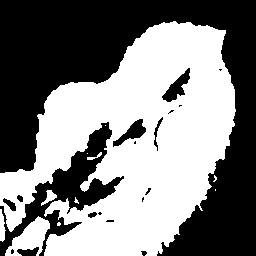

In [11]:
Image.fromarray(threshInv)

In [13]:
from typing import List

def transform_image(im: rgb_image) -> List[rgb_image]:
    cv_im = tensor_to_cv(im)
    mask = get_mask(im)
    shape_image = cv_to_tensor(pcv.analyze.size(img=cv_im, labeled_mask=mask.to(torch.uint8).numpy() * 255, n_labels=1))
    gaussian_img = cv_to_tensor(pcv.gaussian_blur(img=tensor_to_cv(im), ksize=(5, 5), sigma_x=0, sigma_y=None))
    homolog_pts, start_pts, stop_pts, ptvals, chain, max_dist = pcv.homology.acute(img=cv_im, mask=mask.to(torch.uint8).numpy() * 255, win=25, threshold=90)

    imm = cv_im
    for point in homolog_pts:
        imm = cv2.circle(imm, point[0], 1, (255, 0, 0), 2)
    landmarks = cv_to_tensor(imm)
    color_histogram, _ = pcv.visualize.histogram(img=tensor_to_cv(im), mask=mask, hist_data=True, bins=30)
    color_histogram.save("chart.png")
    color_histogram = to_tensor(Image.open("chart.png").convert('RGB'))
    
    
    return [mask, mask * im, shape_image, gaussian_img, landmarks, color_histogram]

images = transform_image(im)

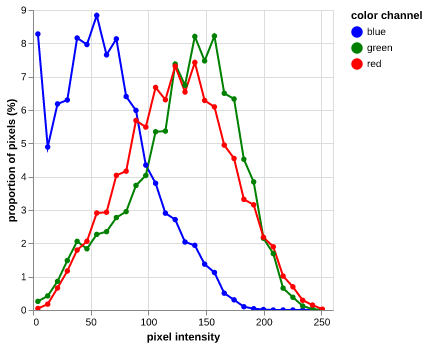

In [104]:
to_pil_image(images[1])
chart = images[5]
import io

# bytes = io.BytesIO()

chart.save("chart.png")
im = Image.open("chart.png").convert('RGB')
# im = Image.fromarray(np.array(im))

In [16]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(images, 3, 2)

TypeError: cannot unpack non-iterable builtin_function_or_method object

torch.Size([3, 347, 434])